# Data Distribution

In [220]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import cv2
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

if "notebooks" in os.getcwd():
    print("Running in Jupyter Notebook")


COLORS = [
    (0, 0, 0), (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184),
    (20, 165, 16), (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122),
    (43, 152, 125), (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198), (70, 250, 116),
    (216, 21, 138), (100, 0, 176), (171, 236, 47), (193, 137, 224), (36, 152, 214), (154, 165, 67), (73, 8, 110),
    (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184), (20, 165, 16),
    (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122), (43, 152, 125),
    (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198), (70, 250, 116), (216, 21, 138)
]

In [221]:
dataDir='data'
dataType='train2020'
annFile='{}/annotations/instances_attributes_{}.json'.format(dataDir,dataType)
maskFolder='{}/annotations/{}/'.format(dataDir,dataType)
imgFolder='{}/images/{}/'.format(dataDir,dataType)

# initialize COCO api for instance annotations
db=COCO(annFile)
d_cats = {x['id']: x['name'] for x in db.dataset['categories']}


loading annotations into memory...
Done (t=3.55s)
creating index...
index created!


In [384]:
for k, v in d_cats.items():
    print(k, ":", v)

0 : shirt, blouse
1 : top, t-shirt, sweatshirt
2 : sweater
3 : cardigan
4 : jacket
5 : vest
6 : pants
7 : shorts
8 : skirt
9 : coat
10 : dress
11 : jumpsuit
12 : cape
13 : glasses
14 : hat
15 : headband, head covering, hair accessory
16 : tie
17 : glove
18 : watch
19 : belt
20 : leg warmer
21 : tights, stockings
22 : sock
23 : shoe
24 : bag, wallet
25 : scarf
26 : umbrella
27 : hood
28 : collar
29 : lapel
30 : epaulette
31 : sleeve
32 : pocket
33 : neckline
34 : buckle
35 : zipper
36 : applique
37 : bead
38 : bow
39 : flower
40 : fringe
41 : ribbon
42 : rivet
43 : ruffle
44 : sequin
45 : tassel


In [236]:

def get_image(img_id):
    img = db.loadImgs(img_id)[0]
    I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))
    return I

def get_mask(img_id):
    file_name = db.loadImgs(img_id)[0]['file_name']
    mask = cv2.imread(f"{maskFolder}/{file_name.split('.')[0]}_seg.png", cv2.IMREAD_GRAYSCALE)
    return mask

def get_annotations(img_id):
    annIds = db.getAnnIds(imgIds=img_id)
    anns = db.loadAnns(annIds)
    return anns

def box_label(image, box, mask=None, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  if mask is not None:
    image = image * (1-mask) + (image + np.array([[list(color)]])) * mask / 2
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  image = cv2.rectangle(image.astype(np.uint8), p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    image = cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    image = cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)
    return image
  
def plot_boxes(img_id, ax=None):
    img = get_image(img_id)
    anns = get_annotations(img_id)

    plt.imshow(img)
    for ann in anns:
        color = COLORS[ann['category_id']]
        bbox = ann['bbox']
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        img = box_label(img, bbox, label=db.loadCats(ann['category_id'])[0]['name'], color=color)

    if ax is not None:
        ax.imshow(img)
        ax.axis('off')
    else:
        plt.imshow(img)
        plt.axis('off')

def plot_mask(mask_id):
    mask = cv2.imread(f"{maskFolder}/{mask_id}", cv2.IMREAD_GRAYSCALE)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    # plt.show()

def overlay_mask(img_file, alpha=0.7, ax=None):
    mask = cv2.imread(f"{maskFolder}/{img_file.split('.')[0]}_seg.png", cv2.IMREAD_GRAYSCALE)
    img = plt.imread(f"{imgFolder}/{img_file}", cv2.IMREAD_COLOR)

    # For all the values in the mask, we will create a new mask with the same shape but with the color of the category
    mask_color = np.zeros((mask.shape[0], mask.shape[1], 3))
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask_color[i, j] = COLORS[mask[i, j]]

    mask_color = mask_color.astype(np.uint8)

    # Combine original image with colored mask
    image = cv2.addWeighted(img, 1 - alpha, mask_color, alpha, 0)

    # image = cv2.addWeighted(img, 1, mask_color, 1, 0)

    if ax is not None:
        ax.imshow(image)
        ax.axis('off')
    else:
        # plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
  

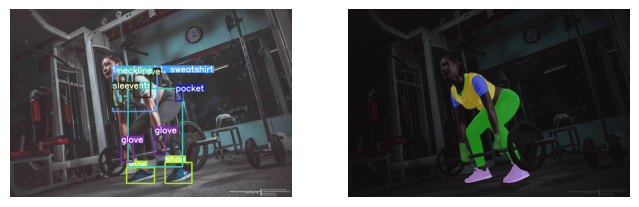

In [232]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ids = db.getImgIds()
rnd_id = np.random.choice(ids, 1)
plot_boxes(img_id=rnd_id, ax=ax[0])

image_file = db.loadImgs(rnd_id)[0]['file_name']

overlay_mask(image_file, ax=ax[1])

## Number of Images per Label

In [233]:
import pandas as pd
from time import time

tic = time()
# Get the annotations for each image (may be useful)
d_annotations = {img_id:get_annotations(img_id) for img_id in db.getImgIds()}
# Categories per image
d_img_class = {k: [d_cats[x['category_id']] for x in v] for k, v in d_annotations.items()}
# Image per category
d_class_img = {d_cats[cat]: db.getImgIds(catIds=cat) for cat in db.getCatIds()}
print("Time elapsed:", time() - tic)

Time elapsed: 0.4585697650909424


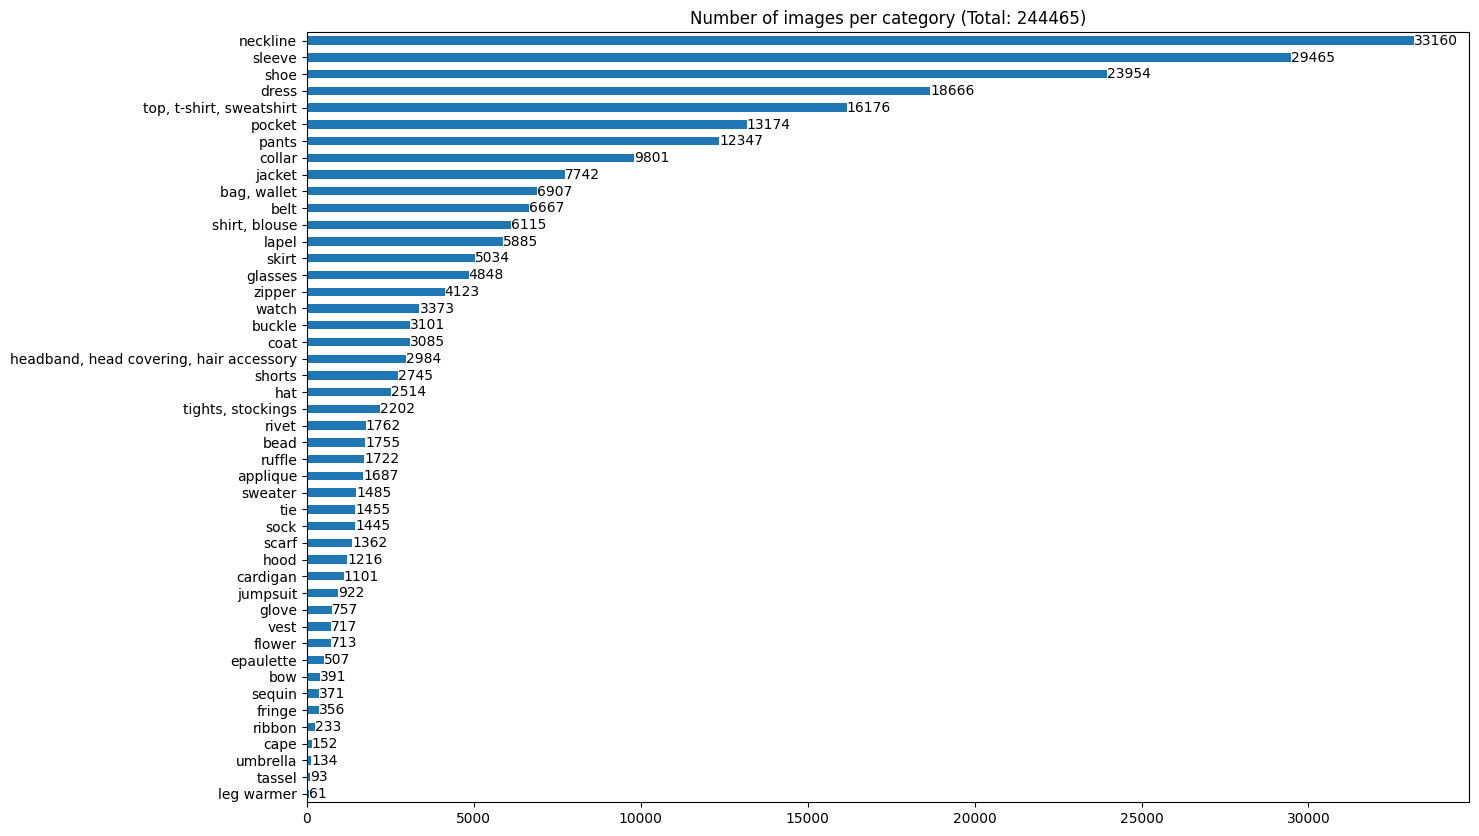

In [234]:
df_class_img = pd.DataFrame({k:[len(v)] for k,v in d_class_img.items()}).T
df_class_img.rename({0:'category'}, axis=1, inplace=True)
total = df_class_img['category'].sum()
fig, ax = plt.subplots(figsize=(15, 10))
df_class_img.sort_values(by='category').plot(kind='barh', title = f"Number of images per category (Total: {total})", ax=ax, legend=False)
for bar in ax.patches:
    plt.text(bar.get_width(), bar.xy[1], f"{bar.get_width()}")

In [203]:
img_filenames = sorted(os.listdir(imgFolder))
mask_filenames = sorted(os.listdir(maskFolder))

assert len(img_filenames) == len(mask_filenames), "Number of images and masks do not match"
print(f"Number of images: {len(img_filenames)}")
print(f"Number of masks: {len(mask_filenames)}")

Number of images: 45623
Number of masks: 45623


## Pixel Ratio per Label

(# of pixels of label j in image i) / (# of pixels in image i)

In [259]:
id = ids[0]
mask = get_mask(id)
mask_vals = mask[mask > 0]
from collections import Counter
d_pixels = Counter(mask_vals)
d_pixels = {d_cats[k]: v for k, v in d_pixels.items()}
d_pixels_rel = {k: v / len(mask_vals) for k, v in d_pixels.items()}
d_pixels_rel, d_pixels

({'skirt': 0.6722188424342864, 'bag, wallet': 0.3277811575657136},
 {'skirt': 96132, 'bag, wallet': 46875})

In [279]:
d_cats

{0: 'shirt, blouse',
 1: 'top, t-shirt, sweatshirt',
 2: 'sweater',
 3: 'cardigan',
 4: 'jacket',
 5: 'vest',
 6: 'pants',
 7: 'shorts',
 8: 'skirt',
 9: 'coat',
 10: 'dress',
 11: 'jumpsuit',
 12: 'cape',
 13: 'glasses',
 14: 'hat',
 15: 'headband, head covering, hair accessory',
 16: 'tie',
 17: 'glove',
 18: 'watch',
 19: 'belt',
 20: 'leg warmer',
 21: 'tights, stockings',
 22: 'sock',
 23: 'shoe',
 24: 'bag, wallet',
 25: 'scarf',
 26: 'umbrella',
 27: 'hood',
 28: 'collar',
 29: 'lapel',
 30: 'epaulette',
 31: 'sleeve',
 32: 'pocket',
 33: 'neckline',
 34: 'buckle',
 35: 'zipper',
 36: 'applique',
 37: 'bead',
 38: 'bow',
 39: 'flower',
 40: 'fringe',
 41: 'ribbon',
 42: 'rivet',
 43: 'ruffle',
 44: 'sequin',
 45: 'tassel'}

In [283]:
# Create a thread pool to process the images in parallel
import concurrent.futures
from collections import Counter
import json

# def process_id(id):
#     mask = get_mask(id)
#     mask_vals = mask[mask > 0]
#     d_pixels = Counter(mask_vals)
#     d_pixels_rel = {k: v / len(mask_vals) for k, v in d_pixels.items()}
#     return d_pixels_rel

# d_pixels_rel_out = {}
# with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
#     futures = {executor.submit(process_id, id): id for id in ids}
#     for future in concurrent.futures.as_completed(futures):
#         id = futures[future]
#         try:
#             result = future.result()
#             for k, v in result.items():
#                 d_pixels_rel_out.setdefault(k, []).append(v)
#         except Exception as exc:
#             print(f'Error processing id {id}: {exc}')

# d_pixels_rel_out_exp = {d_cats[int(k) - 1]: v for k, v in d_pixels_rel_out.items()}
with open('data/d_pixels_rel_out.json', 'w') as f:
    json.dump(d_pixels_rel_out_exp, f)

with open('data/d_pixels_rel_out.json', 'r') as f:
    d_pixels_rel_out = json.load(f)

d_pixels_rel_out

{'watch': [0.01007094453033565,
  0.0022366087787947585,
  0.00886203069116792,
  0.0029764338397631936,
  0.0073909197271923065,
  0.0011510587377510134,
  0.0018605360478859277,
  0.006879666538516015,
  0.006112446997925806,
  0.004183392546794014,
  0.00796767074603766,
  0.0014647337189213551,
  0.007871439477639896,
  0.012605487094382261,
  0.0051652837294899985,
  0.004884329414363725,
  0.004529025726642216,
  0.00740959059946067,
  0.0025240832039513704,
  0.008406988309031882,
  0.0031254078983626054,
  0.005646938715826583,
  0.0038634799474441595,
  0.00874950641145541,
  0.0022228045565951936,
  0.004788180035569338,
  0.008173538968468261,
  0.0050375272046809,
  0.00816905615292712,
  0.0069900444821012495,
  0.011690616192895168,
  0.008129823280809492,
  0.005710530950671309,
  0.0038799661013487986,
  0.006237204208922535,
  0.003023085379259802,
  0.002631594650881077,
  0.0013869259117386768,
  0.006883106023597963,
  0.0019621495031331097,
  0.003837719298245614,


In [284]:
d_pixels_rel_out.keys()

dict_keys(['watch', 'dress', 'neckline', 'sequin', 'shoe', 'headband, head covering, hair accessory', 'top, t-shirt, sweatshirt', 'skirt', 'sleeve', 'bag, wallet', 'shorts', 'jacket', 'lapel', 'bead', 'belt', 'collar', 'zipper', 'pants', 'ribbon', 'ruffle', 'pocket', 'jumpsuit', 'vest', 'buckle', 'rivet', 'shirt, blouse', 'hat', 'coat', 'tights, stockings', 'glasses', 'sweater', 'fringe', 'hood', 'scarf', 'applique', 'tie', 'sock', 'cardigan', 'bow', 'umbrella', 'glove', 'tassel', 'epaulette', 'flower', 'cape', 'leg warmer'])

In [322]:
df_pixels_rel = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d_pixels_rel_out.items() ]))

pixels_mean = pd.DataFrame(df_pixels_rel.mean())#
#.reset_index(drop=False).sort_values()
pixels_mean = pixels_mean.reset_index(drop=False).\
                          rename({'index':'category', 0:'mean'}, axis=1).\
                          sort_values(by='mean', ascending=False)


,category,mean
1,dress,0.777932
21,jumpsuit,0.732483
44,cape,0.563083
7,skirt,0.462080
30,sweater,0.428699
27,coat,0.423211
17,pants,0.364888
39,umbrella,0.355266
6,"top, t-shirt, sweatshirt",0.350848
37,cardigan,0.324960


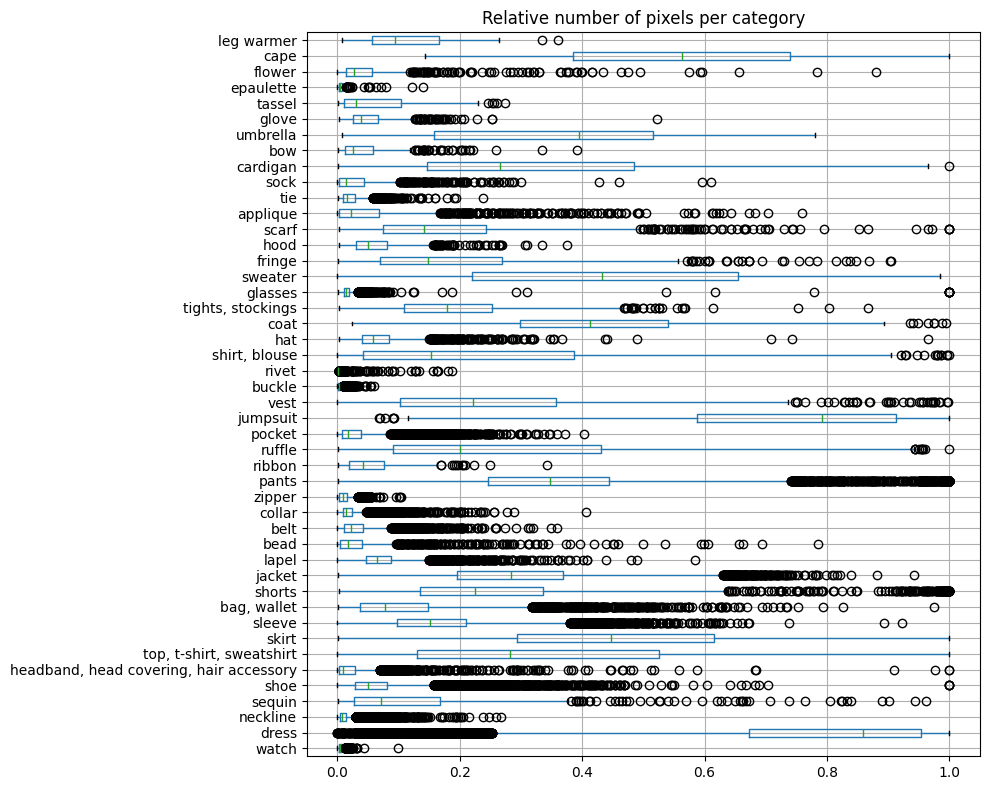

In [345]:
# Boxplot of the relative number of pixels per category

fig, ax = plt.subplots(figsize=(10, 8))
df_pixels_rel = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d_pixels_rel_out.items() ]))
df_pixels_rel.boxplot(rot=0,  vert=False, ax=ax)
ax.set_title("Relative number of pixels per category")
plt.tight_layout()

<Axes: title={'center': 'Mean relative number of pixels per category'}>

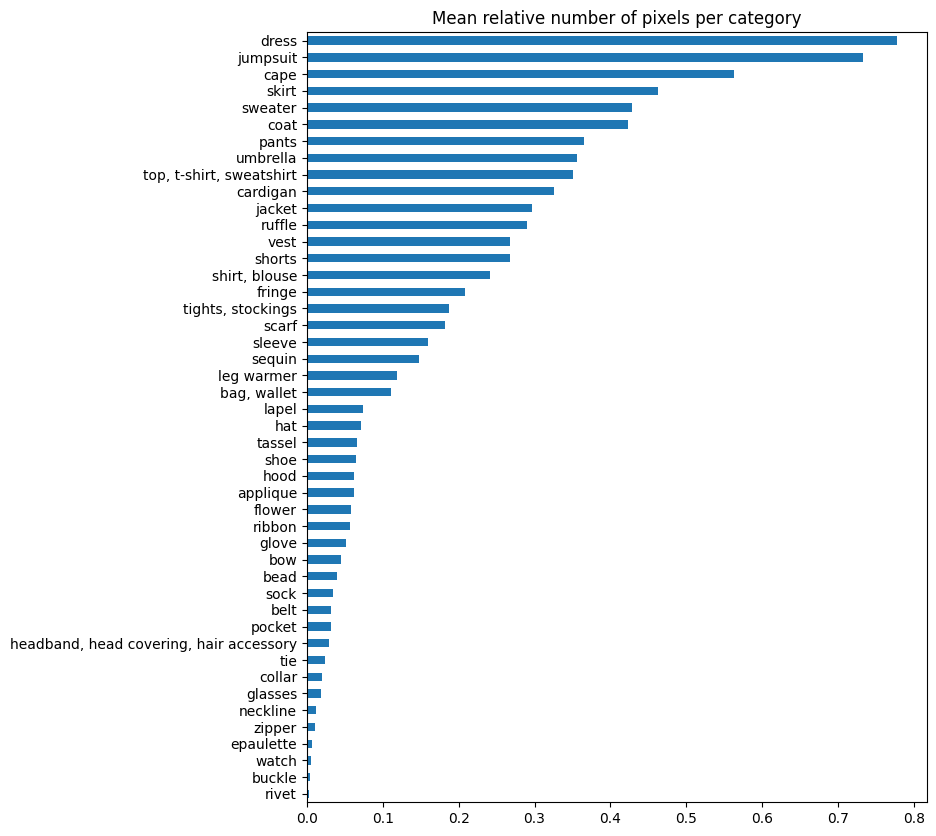

In [346]:
pixels_mean = df_pixels_rel.mean()
pixels_mean.sort_values().plot(kind='barh', title='Mean relative number of pixels per category')



In [349]:
pixels_mean

rivet                                      0.002846
buckle                                     0.003842
watch                                      0.005549
epaulette                                  0.006806
zipper                                     0.010677
neckline                                   0.011401
glasses                                    0.018401
collar                                     0.020393
tie                                        0.023705
headband, head covering, hair accessory    0.029695
pocket                                     0.031648
belt                                       0.031878
sock                                       0.033917
bead                                       0.039358
bow                                        0.044590
glove                                      0.051349
ribbon                                     0.056880
flower                                     0.057698
applique                                   0.061507
hood        

In [356]:
df_pixels_rel["dress"].mean()

0.7779321199204967

In [362]:
pixels_mean.index.size

46

In [361]:
(pixels_mean.index == df_pixels_rel.loc[:, pixels_mean.index].columns).shape

(46,)

In [370]:
df_pixels_rel.loc[:, pixels_mean.index]

,rivet,buckle,watch,epaulette,zipper,neckline,glasses,collar,tie,"headband, head covering, hair accessory",...,cardigan,"top, t-shirt, sweatshirt",umbrella,pants,coat,sweater,skirt,cape,jumpsuit,dress
0,0.000214,0.011960,0.010071,0.011063,0.010176,0.006199,0.016187,0.010267,0.010133,0.011230,...,0.108886,0.207097,0.244933,0.438606,0.393410,0.077334,0.739549,0.344151,0.775459,0.983730
1,0.000183,0.006317,0.002237,0.003549,0.016505,0.007458,0.012188,0.011679,0.022050,0.003305,...,0.160447,0.063889,0.478211,0.432255,0.414567,0.395426,0.878178,0.143788,0.624722,0.947259
2,0.000848,0.001544,0.008862,0.002579,0.018940,0.024844,0.008722,0.014652,0.043721,0.002011,...,0.080439,0.306304,0.318425,0.531111,0.413147,0.369891,0.616282,0.937209,0.853906,0.580415
3,0.000652,0.004574,0.002976,0.004538,0.011763,0.003592,0.019361,0.017231,0.019831,0.024985,...,0.103750,0.738529,0.063127,0.232911,0.543033,0.300595,0.321441,0.248718,0.996125,0.827281
4,0.000450,0.004191,0.007391,0.139573,0.014199,0.017126,0.014489,0.066477,0.042391,0.061702,...,0.201463,0.155908,0.662453,0.504889,0.412741,0.270962,0.573431,0.315149,0.906950,0.902787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32585,NaN,NaN,NaN,NaN,NaN,0.008706,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32586,NaN,NaN,NaN,NaN,NaN,0.012583,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32587,NaN,NaN,NaN,NaN,NaN,0.020937,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32588,NaN,NaN,NaN,NaN,NaN,0.005423,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


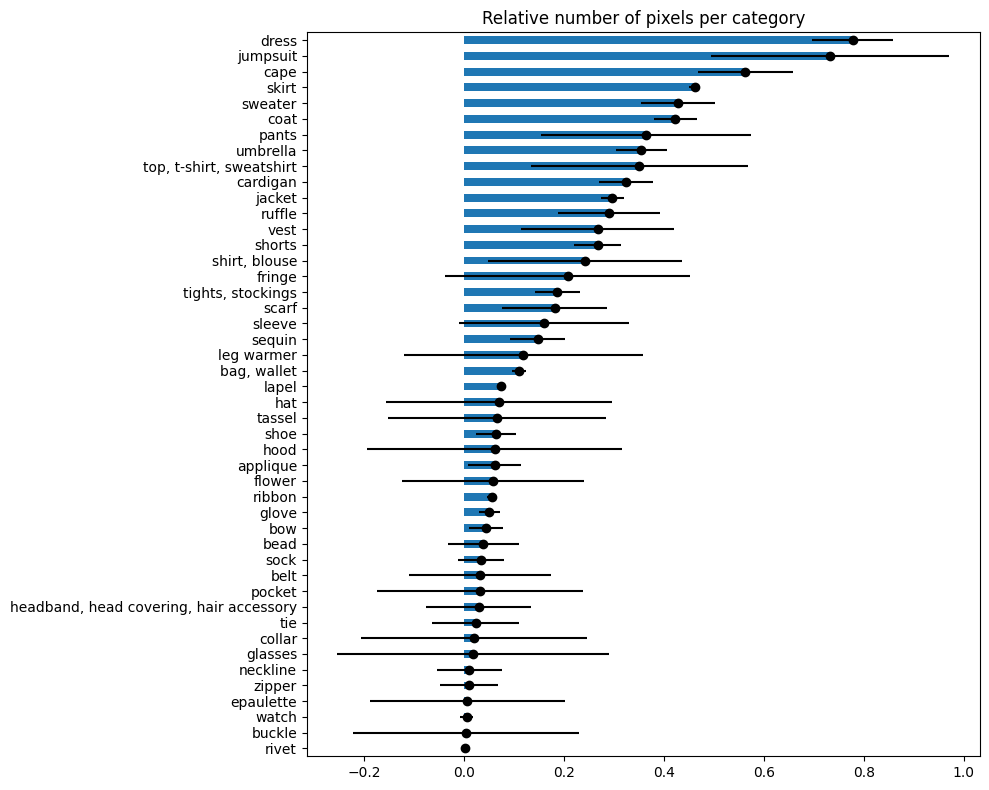

In [378]:
fig, ax = plt.subplots(figsize=(10, 8))
df_pixels_rel = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d_pixels_rel_out.items() ]))

pixels_mean = df_pixels_rel.mean().sort_values()
pixels_mean.plot(kind='barh', title='Mean relative number of pixels per category', ax=ax, 
                 )
plt.errorbar(pixels_mean, range(pixels_mean.size), xerr=df_pixels_rel.std(), fmt='o', color='k')

c="k"
ax.set_title("Relative number of pixels per category")
plt.tight_layout()

<Axes: >

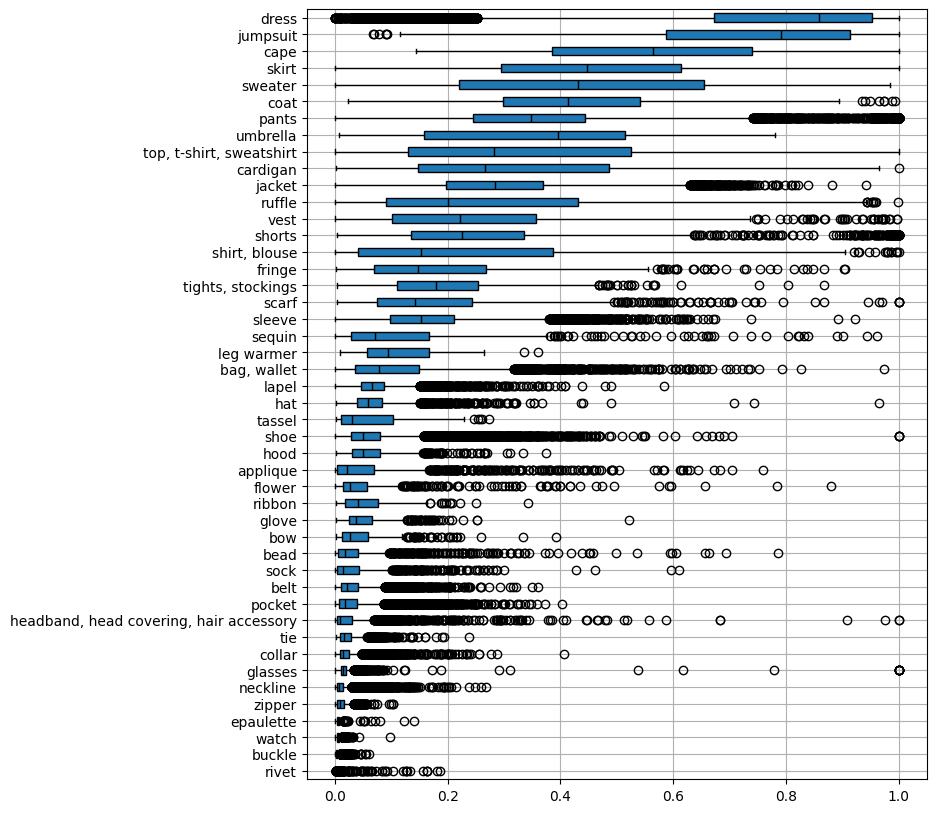

In [379]:
df_pixels_rel.loc[:, pixels_mean.index].boxplot(rot=0,  
                                                vert=False, 
                                                patch_artist=True, 
                                                boxprops=dict(color=c), 
                                                whiskerprops=dict(color=c), 
                                                capprops=dict(color=c), 
                                                medianprops=dict(color=c))